# General Use Examples

- Import the required packages:

In [1]:
from sofia_redux.toolkit.resampling.resample import Resample
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from skimage.data import chelsea
from sklearn.datasets import load_boston
%matplotlib inline

## 3-Dimensional resampling example

The purpose here is to show how to parse data into the resampler in multiple dimensions and showcases the relative speed of the algorithm.

- Create a 3-D gaussian test data set of > 2 million points

In [2]:
gcube = np.zeros((128, 128, 128))
gcube[64, 64, 64] = 1.0
gcube = gaussian_filter(gcube, 8.0)
gcube /= gcube.max()

# Create cube coordinates
z, x, y = np.mgrid[:128, :128, :128]
coordinates = np.vstack([a.ravel() for a in [x, y, z]])

- The following step is responsible for the most time for this specific example (a couple of seconds on my laptop).  Once the resampler is built, subsequent steps can be completed relatively quickly.

In [3]:
resampler3d = Resample(coordinates, gcube.ravel(), order=2)

- Create a line profile along the first dimension (and the center of the other two):

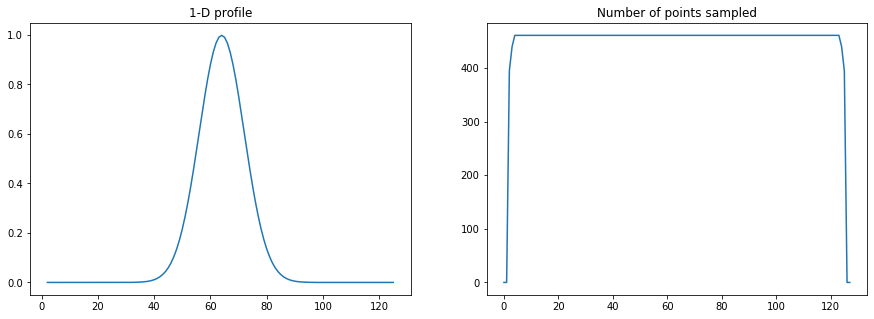

In [5]:
# Serial processing
profile, counts = resampler3d(
    np.arange(128), 64, 64, get_counts=True, smoothing=0.5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(profile.ravel())
plt.title("1-D profile")
plt.subplot(1, 2, 2)
plt.plot(counts.ravel())
_ = plt.title("Number of points sampled")

The profile should look good and we can see that the majority of resampled points each used around 450 samples to create the fit.  This is pretty cool considering that for each coordinate we need to resample at the algorithm searches a dataspace of over 2 million points, finds which points are within the `window` range, and finally calculates the 3-dimensional polynomial fit for each point using ~450 samples each.

- In the next example, we'll use the existing resampler to generate a 2-D image slice at double resolution.  In this case we'll using parallel processing using all cores by specifying jobs=-1:

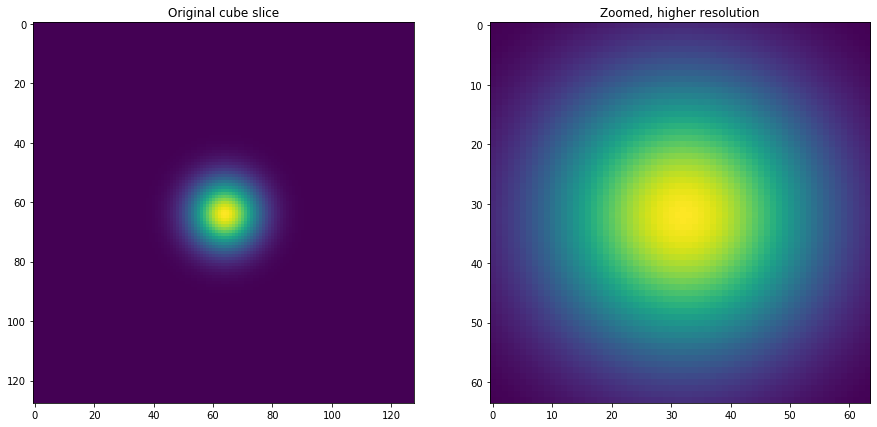

In [7]:
xout = np.arange(64, dtype=float) * 0.5 + 48
yout = np.arange(64, dtype=float) * 0.5 + 48
zout = 64

# multithreading with all cores
image = resampler3d(xout, yout, zout, smoothing=0.25, jobs=-1)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(gcube[64])
plt.title("Original cube slice")
plt.subplot(1, 2, 2)
plt.title("Zoomed, higher resolution")
_ = plt.imshow(image[0])

## Filling in missing data

The resampler can be used to fill missing value, as it does in the following example with an RGB image.  In this case we are making use of the resampler's ability to process multiple sets together.  For RGB images we have 3 datasets (Red, Green, Blue) all sharing the same coordinate system.

- Load an image and corrupt it

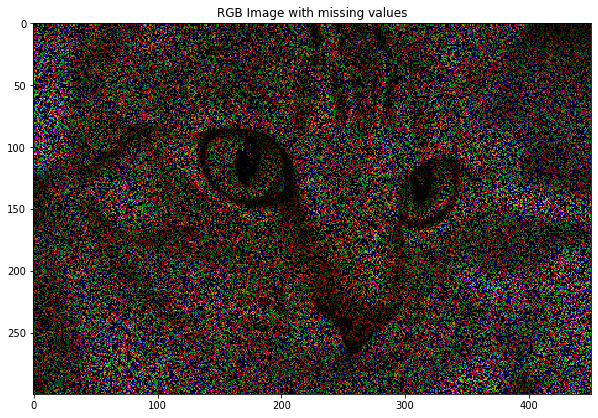

In [8]:
original = chelsea()
sick_kitty = original.astype(float)
bad_pix = np.random.random(sick_kitty.shape) < 0.7  # corrupt ~70 percent of image

# Note: the resampler will automatically mask out NaN values.
sick_kitty[bad_pix] = np.nan
plt.figure(figsize=(10, 10))
plt.imshow(sick_kitty / 255)
_ = plt.title("RGB Image with missing values")

- Format the data so that it can be parsed into the resampler:

In [9]:
s = original.shape

# pixel coordinates
y, x = np.mgrid[:s[0], :s[1]]

# supply to the resampler as a numpy array of shape (ndim, ndata)
kitty_coords = np.vstack([x.ravel(), y.ravel()])

# the output grid to resample onto - Note, this could be anything,
# but we are going to use the original grid.
grid = np.arange(s[1]), np.arange(s[0])

# data should be supplied as a numpy array of shape (nsets, ndata)
data = np.empty((s[2], s[0] * s[1]))
for frame in range(s[2]):
    data[frame] = sick_kitty[:, :, frame].ravel()

- Perform the resampling:

In [10]:
vet = Resample(kitty_coords, data, window=5, order=2, mode='extrapolate')
# Here relative_smooth means that we are using a weighting function
# (see the docs) with alpha=1 pixel, not 1*`window`.
# fit_threhold replaces any polynomial fits that are greater than
# 2 * weighted_std(samples) used to fit that pixel with the weighted
# mean.
happy_cat = vet(*grid, smoothing=1, relative_smooth=False,
                fit_threshold=2, jobs=-1)

Get the resampled data back into the correct RBG image format.  There may be a few color effects, but overall, the reconstruction is pretty good for 70 percent data corruption.  

We could have also sped things up by just fitting for the missing pixels rather than the entire image which would have the added benefit of preserving edges (polynomial resampling will always smooth edges).  However, this example is here to show you how to process multiple datasets simultaneously.

- Plot the result:

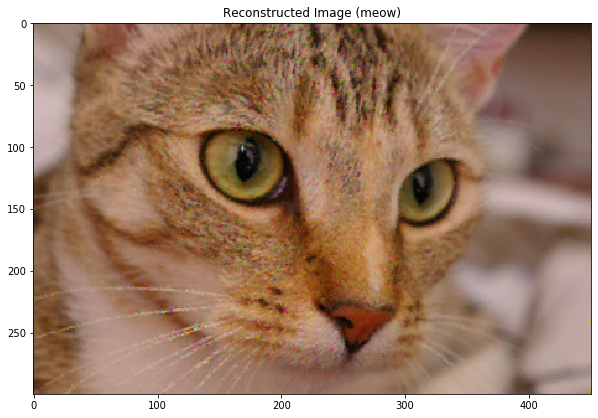

In [11]:
img = np.clip(np.moveaxis(happy_cat, 0, -1).astype(int), 0, 255)
plt.figure(figsize=(10, 10))
plt.imshow(img)
_ = plt.title("Reconstructed Image (meow)")

## Resampling of Irregular Data

- The following example shows how we can resample any permutation of irregular or regular input coordinates onto regular or irregular output coordinates.

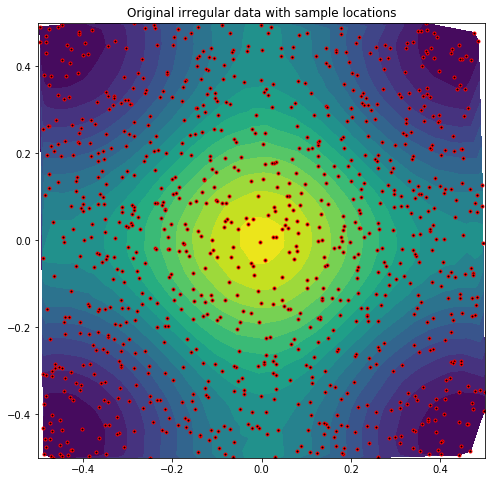

In [12]:
random = np.random.RandomState(41)
c_ireg = np.vstack([random.rand(1000) - 0.5,
                    random.rand(1000) - 0.5])
z_ireg = np.sinc(c_ireg[0] * np.pi) + np.sinc(c_ireg[1] * np.pi)
plt.figure(figsize=(8, 8))
plt.tricontourf(*c_ireg, z_ireg, 20)
plt.scatter(*c_ireg, marker='.', c="black", edgecolors="red")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
_ = plt.title("Original irregular data with sample locations")

### Irregular to regular gridding

- Resample onto a regular grid using the `'edges'` and `'extrapolate'` modes:

In [13]:
x_ordinates = np.linspace(-0.5, 0.5, 100)
y_ordinates = np.linspace(-0.5, 0.5, 100)

edge_resampler = Resample(c_ireg, z_ireg, mode='edges')
edged = edge_resampler(x_ordinates, y_ordinates,
                       smoothing=0.2, edge_threshold=0.5)

extrapolate_resampler = Resample(c_ireg, z_ireg, mode='extrapolate')
extrapolated = extrapolate_resampler(x_ordinates, y_ordinates,
                                     smoothing=0.2, edge_threshold=0.0)

- Plot the results:

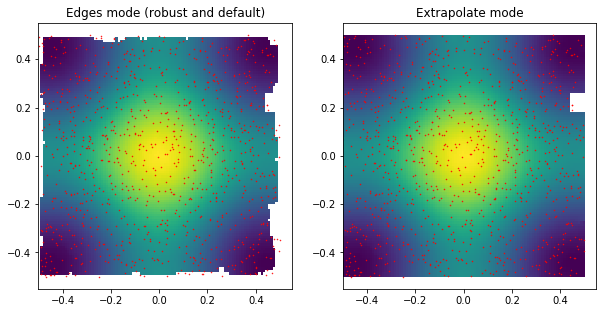

In [14]:
plt.figure(figsize=(10, 10))

# Plot the data using 'edges' mode
plt.subplot(1, 2, 1)
plt.imshow(edged, extent=[-0.5, 0.5, -0.5, 0.5])
plt.scatter(*c_ireg, marker='.', s=1, color='red')
plt.title("Edges mode (robust and default)")

# Plot the data using `extrapolate` mode
plt.subplot(1, 2, 2)
plt.imshow(extrapolated, extent=[-0.5, 0.5, -0.5, 0.5])
plt.scatter(*c_ireg, marker='.', s=1, color='red')
_ = plt.title("Extrapolate mode")

NaN (white) pixels are a consequence of an insufficient sample distributation at a location for the selected `mode`.  `'extrapolate'` can be used to recover more of the fit near the edges, but with that comes the possibility that the fit explodes, especially for high fit orders.  `'edges'` mode is the default and essentially guarantees the fit is bounded and protected from singular matrix errors.

### Irregular to irregular gridding

Specifying irregular output grids is done by supplying a single argument to the initialized resampler containing the irregular output coordinates.  This should be a numpy array of shape (n_dimensions, n_coordinates).  For the following example, we'll just use the `edge_resampler` that was created above:

- Resample a set of irregular coordinates onto a different set of irregular coordinates:

In [15]:
ireg_out = np.vstack([random.rand(512) - 0.5, random.rand(512) - 0.5])
ireg_resampled = edge_resampler(ireg_out, smoothing=0.5)

- Plot the results:

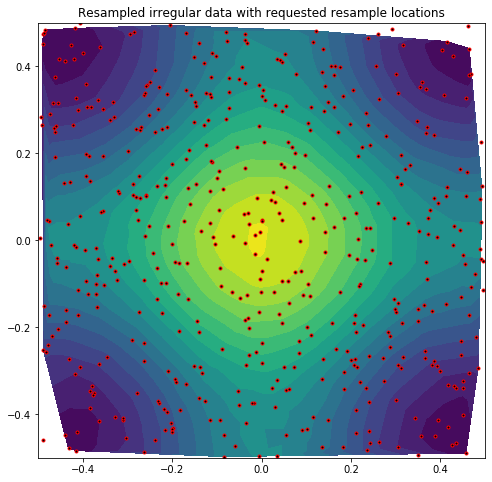

In [16]:
# We need to remove NaN values so `tricontourf` can work
mask = np.isfinite(ireg_resampled)
ireg_plotc = ireg_out[:, mask]
ireg_plotz = ireg_resampled[mask]

plt.figure(figsize=(8, 8))
plt.tricontourf(*ireg_plotc, ireg_plotz, 20)
plt.scatter(*ireg_out, marker='.', c="black", edgecolors="red")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
_ = plt.title("Resampled irregular data with requested resample locations")

Note that some requested sample positions resulted in NaN values.  The rules for regular and irregular gridding are identical as they are not treated any differently within the algorithm.  `edges` and `extrapolate` mode rules still apply.

## Resampling over multiple dimensions with different units

- Get some test data with different feature units:

In [17]:
dataset = load_boston()
crime= dataset['data'][:, 0]  # per capita crime rate
polution = dataset['data'][:, 4]  # nitric oxides concentration (parts per 10 million)
poverty = dataset['data'][:, 12]  # lower status of the population

- Create the resampler using various windows to reflect the units:

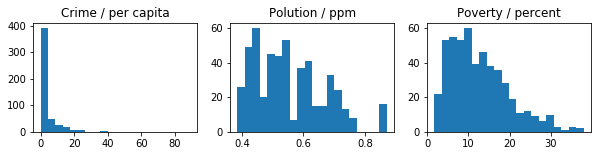

In [18]:
plt.figure(figsize=(10, 2))
# Crime is in 'people' units.  Looks like a powerlaw distribution, so
# I would use a large window with a small smoothing factor.
c_win, c_smooth = 5.0, 1.0
plt.subplot(1, 3, 1)
plt.hist(crime, 20)
plt.title("Crime / per capita")

# polution is in parts per million, fairly well distributed
p_win, p_smooth = 0.3, 0.1
plt.subplot(1, 3, 2)
plt.hist(polution, 20)
plt.title("Polution / ppm")

# poverty is a percentage, fairly well distributed
v_win, v_smooth = 4.0, 2.0
plt.subplot(1, 3, 3)
plt.hist(poverty, 20)
_ = plt.title("Poverty / percent")

- See how polution and poverty vary with crime by creating a resampler.  We have defined a window for each feature.

In [19]:
r = Resample(np.vstack([poverty, polution]), crime,
             window=[v_win, p_win], mode='edges')

- Resample onto a grid using previously defined smoothing parameters.  Note that we are using the `edge_threshold` parameter to reduce edge artifacts.  Setting 0 < `edge_threshold` < 1 will clip edges of the final fit.  This results in the smooth edges seen in the image below.

In [20]:
vmin, vmax = poverty.min(), poverty.max()
pmin, pmax = polution.min(), polution.max()
poverty_out = np.linspace(vmin, vmax, 100)
polution_out = np.linspace(pmin, pmax, 100)
crime_out = r(poverty_out, polution_out,
              smoothing=[v_smooth, c_smooth],
              relative_smooth=False,
              edge_threshold=0.6)

- Create the plot:

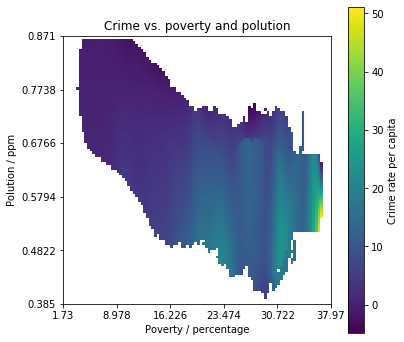

In [21]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
plt.imshow(crime_out, extent=[0, 100, 0, 100])
cbar = plt.colorbar(label="Crime rate per capita")
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xticklabels(np.linspace(vmin, vmax, 6))
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(np.linspace(pmin, pmax, 6))
plt.xlabel("Poverty / percentage")
plt.ylabel("Polution / ppm")
_ = plt.title("Crime vs. poverty and polution")